# Interface gap-filling code to MBHB code

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [18]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)

In [19]:
# define function to print all attributes of hdf5 file recursively 
# from the LDC quicklook notebooks
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")
# print all dataset attributes (useful to see what's inside the HDF5 file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


### 1.2. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

The import function `load_tdi_timeseries` also builds the missing TDI dataset:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [20]:
# Print the tdi dataset object
print(fid['obs/tdi'])

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">


In [21]:
from read_ldc_data import load_tdi_timeseries

Let's load all datasets as numpy-recarray objects in a single dictionary `tdi`:

In [22]:
tdi = load_tdi_timeseries(fname = './data/LDC2_spritz_mbhb1_training_v1.h5')
tdi

{'obs': array([( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16),
        ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16),
        ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15),
        ...,
        (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21),
        (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21),
        (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)],
       dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 'clean': array([( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16),
        ( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16),
        ( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15),
        ...,
        (11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21),
        (11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21),
        (11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)],
       dtype=[('t', 

Let's take a look at the `'obs'` dataset:

In [23]:
tdi['obs']

array([( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16),
       ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16),
       ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15),
       ...,
       (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21),
       (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21),
       (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)],
      dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')])

In [24]:
# dataset is a numpy.recarray object with the length of the data time-series and fields ['t','X','Y','Z']
print(tdi['obs'])
print(tdi['obs'].dtype)

[( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16)
 ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16)
 ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15) ...
 (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21)
 (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21)
 (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)]
[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


Set up dataset constant values:

In [25]:
# number of samples to skip at the beginning of the file
skip = 100 
# length of time-series
ndata = len(tdi['obs'][skip:])
# time step
dt = tdi['obs']['t'][1]-tdi['obs']['t'][0]
# sampling frequency
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


## 2. Build orthogonal TDI combinations

We can proceed in two different ways to build orthogonal TDI combinations for all the datasets of our interest, i.e. `n+s`, `s`, `n`, `n+s+g` `n+g` data, according to our needs.

1. We can create separate numpy rec-arrays, one for each separate dataset
2. We can create a dictionary containing orthogonal TDI combinations for all imported datasets them


Each of these can then be wired into the Spritz analysis.

In [26]:
from bayesdawn.connect.read_ldc_data import build_orthogonal_tdi

In [27]:
# option 1 - separate numpy rec-arrays
td_datans = build_orthogonal_tdi(tdi['clean'])
td_datas  = build_orthogonal_tdi(tdi['sky'])
td_datan  = build_orthogonal_tdi(tdi['noise'])
td_datag  = build_orthogonal_tdi(tdi['clean_gapped'])
td_datang = build_orthogonal_tdi(tdi['noise_gapped'])
print(td_datans.dtype.names)

# # option 2 - single dictionary containing all numpy recarrays
# data = build_orthogonal_tdi(tdi)
# print(data.keys())
# print(data['obs'].dtype.names)

('t', 'A', 'E', 'T')


## 3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

In [28]:
from bayesdawn.connect.timedomain_fill_gaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

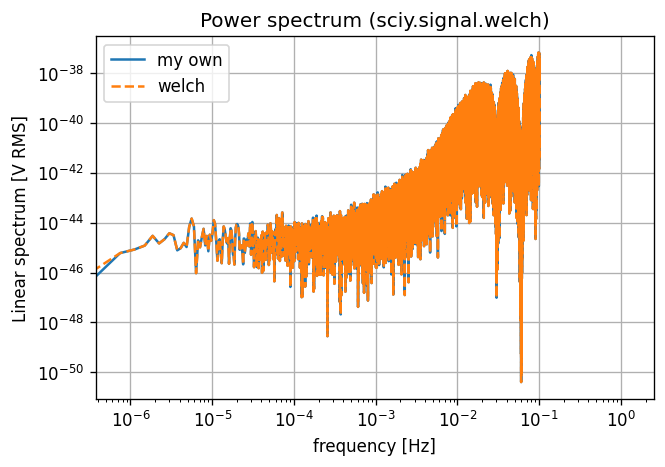

In [29]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(td_datan, chan = 'A', plot = True)

In [36]:
# generate data in the right format for the MBHB search code
# split needs to be set to True

# noise data
datan, psddatan, scalefacn = generate_freq_data(td_datan, split=True)
# noise + signal data
datans, psddatans, scalefacns = generate_freq_data(td_datans, split=True)
# signal data
data, psddata, scalefac = generate_freq_data(td_datas, split=True)

In [31]:
for param, val in zip(fid['sky/cat'].attrs.keys(),fid['sky/cat'][()]):
    print(param, ':', val)

CoalescenceTime : -0.30300442294174235
Distance : 1.2925183861048521
EclipticLatitude : 1.2031361791056812
EclipticLongitude : 2.097303543065685
Inclination : 0.747377
InitialAzimuthalAngleL : 0.8388
InitialPolarAngleL : 1323277.47932
Mass1 : 612485.5060299999
Mass2 : 11526944.921879262
PhaseAtCoalescence : 1.2201968860015653
PolarAngleOfSpin1 : 2.6919824500032945
PolarAngleOfSpin2 : 1.808398497592109
Polarization : 1.73941
Redshift : 13470.983558972537
Spin1 : 31558149.763545603
Spin2 : 3.0


In [32]:
fs=data[:,0]
df=data[1,0]-data[0,0]

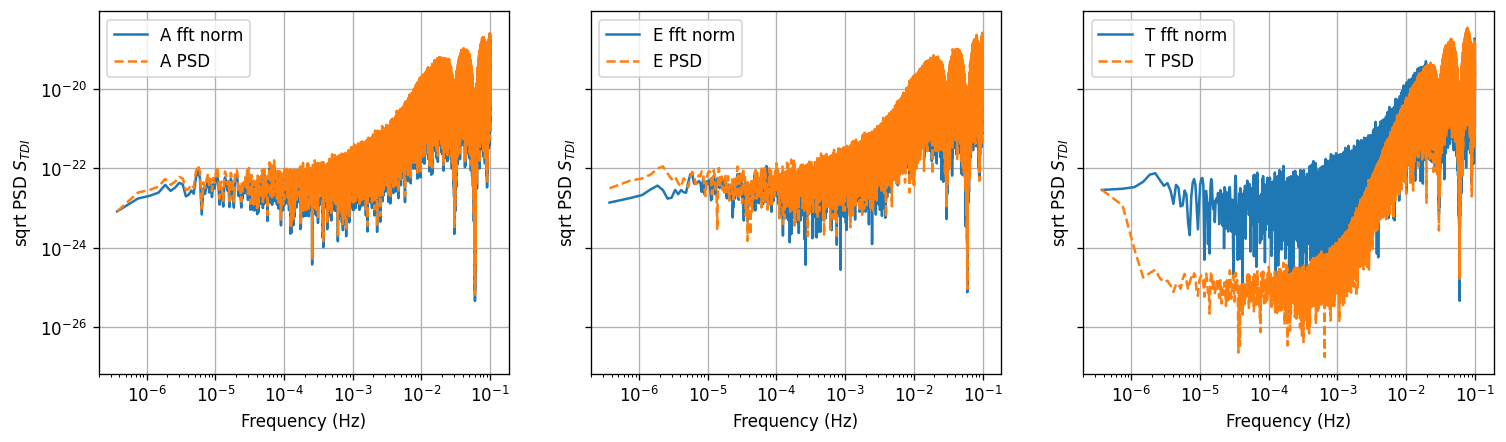

In [42]:
# plot data
fig, ax = plt.subplots(1,3,figsize=(15,4),dpi=120, sharey=True)
ax[0].loglog(datan[:,0],np.sqrt(scalefacn)*np.absolute(datan[:,1]+1j*datan[:,2]), label='A fft norm')
ax[1].loglog(datan[:,0],np.sqrt(scalefacn)*np.absolute(datan[:,3]+1j*datan[:,4]), label='E fft norm')
ax[2].loglog(datan[:,0],np.sqrt(scalefacn)*np.absolute(datan[:,5]+1j*datan[:,6]), label='T fft norm')

ax[0].loglog(psddatan[:,0], np.sqrt(psddatan[:,1]), ls='--', label='A PSD')
ax[1].loglog(psddatan[:,0], np.sqrt(psddatan[:,2]), ls='--', label='E PSD')
ax[2].loglog(psddatan[:,0], np.sqrt(psddatan[:,3]), ls='--', label='T PSD')

for i in range(3):
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel(r'sqrt PSD $S_{TDI}$')
    ax[i].legend()
    ax[i].grid()                                                

## 2. Load the corresponding `ldc` noise model
It is also now possible to produce this kind of model from tabulated PSD data. 

- the Spritz `ldc` noise models can be easily ported to `lisabeta`

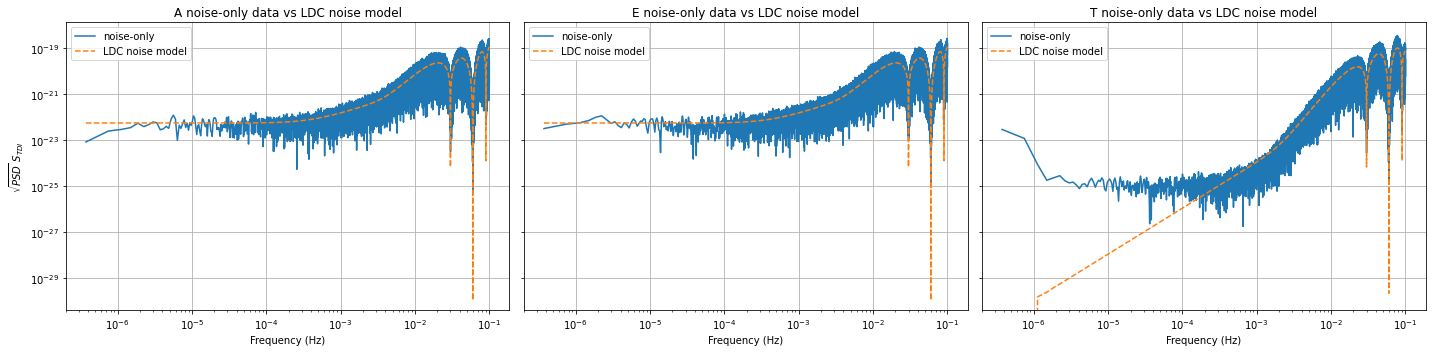

In [34]:
# Load noise models from ldc
# they can be translated easily into lisabeta
from ldc.lisa.noise import get_noise_model

# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, datan[:,0])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=datan[:,0])
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(datan[:,0], np.sqrt(psddatan[:,list(S.keys()).index(tdi)+1]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(datan[:,0], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

In [35]:
# print the SNR level for each TDI combination 

# usual SNR definition: numerical integration of the ratio between 
# the absolute value of the TDI data and its noise PSD, multiplied by 4


SNR2A=sum(np.abs(data[:,1]+1j*data[:,2])**2/S['A'])*4*df
print("A SNR:", np.sqrt(SNR2A), "\t SNR^2:", SNR2A)

SNR2E=sum(np.abs(data[:,3]+1j*data[:,4])**2/S['E'])*4*df
print("E SNR:", np.sqrt(SNR2E), "\t SNR^2:", SNR2E)

SNR2T=sum(np.abs(data[:,5]+1j*data[:,6])**2/S['T'])*4*df
print("T SNR:", np.sqrt(SNR2T), "\t SNR^2:", SNR2T)

print("Total SNR:", np.sqrt(SNR2A+SNR2E+SNR2T))

A SNR: 2.6507894958059737 	 SNR^2: 7.026684951075288
E SNR: 2.532665207994155 	 SNR^2: 6.414393055784076
T SNR: inf 	 SNR^2: inf
Total SNR: inf


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_4179/504645778.py:13: RuntimeWarning: divide by zero encountered in true_divide
  SNR2T=sum(np.abs(data[:,5]+1j*data[:,6])**2/S['T'])*4*df


## 3. PLOT FUNCTIONS NEED TO BE FIXED --- STOP HERE
For comparing spectra, and compare data with noise models.

Here we compare the three data realizations (noise, signal and noise + signal) and evaluate the gaussianity of the noise realization.

n= 267790
nbins= 517


NameError: name 'S_A' is not defined

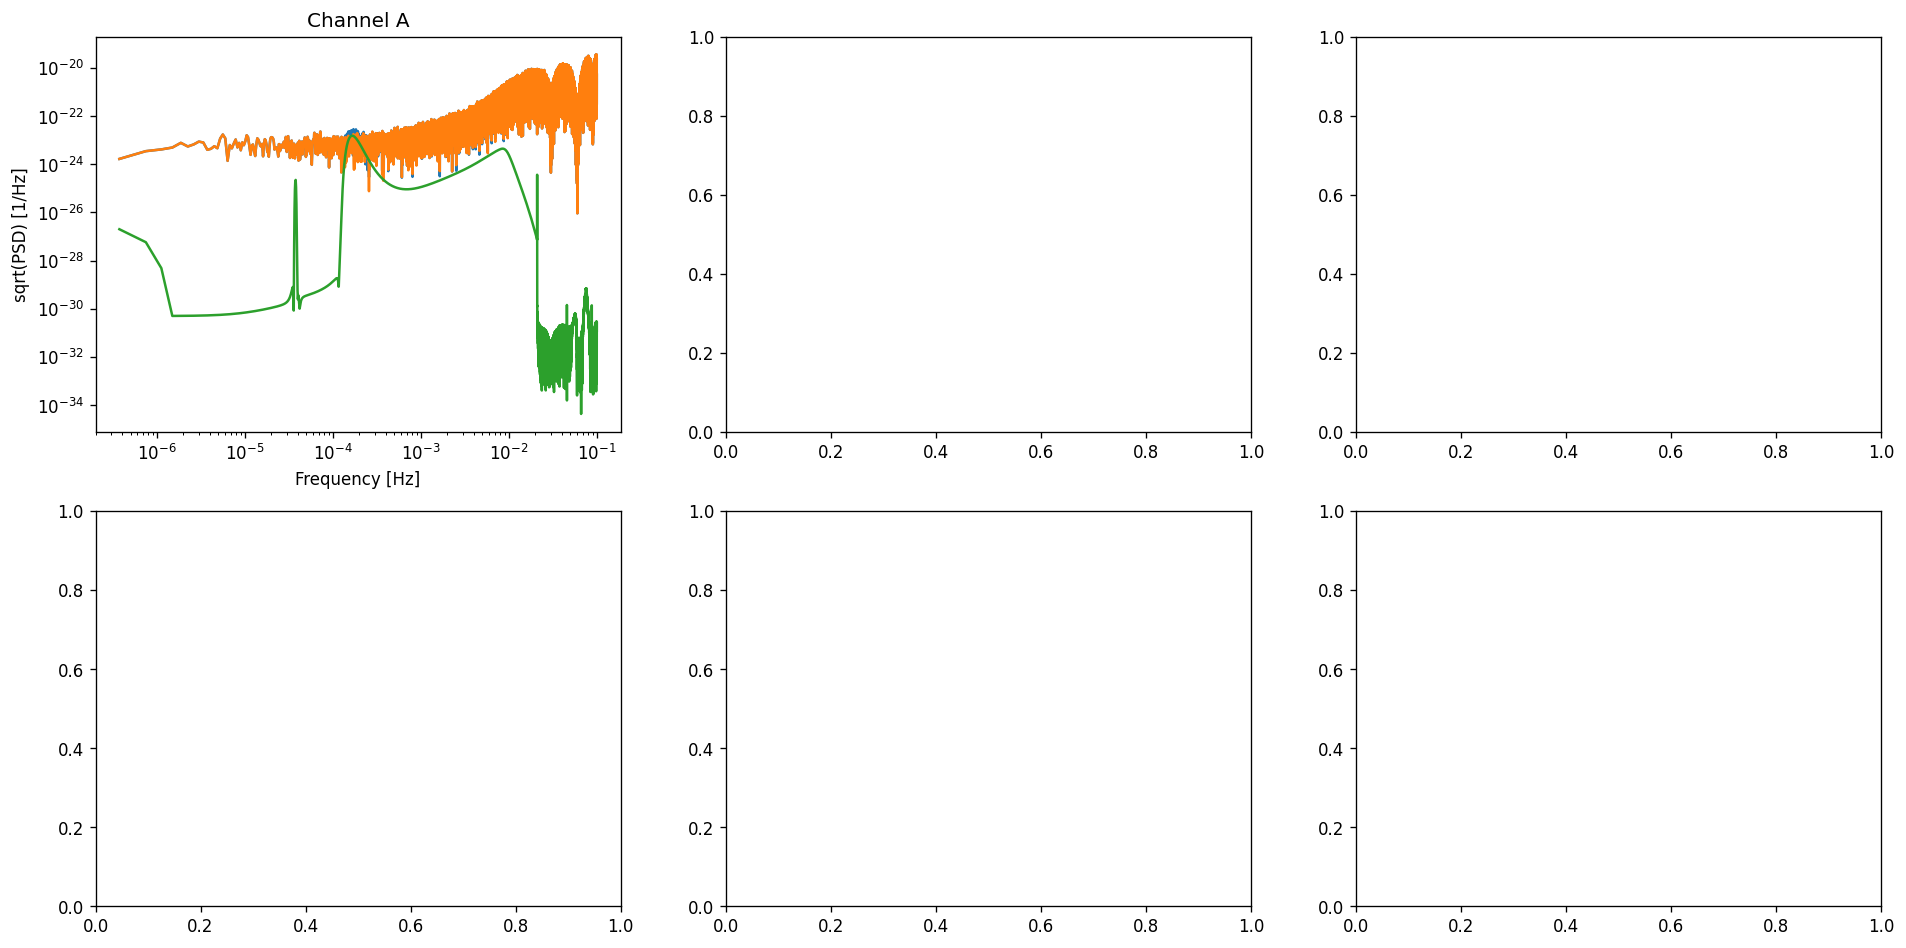

In [30]:
# first we're gonna test the plotting function
from scipy.stats import norm

# length of noise data
nn=len(datan)
print('n=',nn)

# assess number of bins from noise data
nbins=int(np.sqrt(nn))
print('nbins=',nbins)

# generate x data for histogram
x=np.linspace(-6,6,nbins)

# assess entity of scale factor (one-sided psd?)
scalefac=np.sqrt(4*df)
    
# tdi label names
names = ['A', 'E', 'T']

fig, axs = plt.subplots(2,3,figsize=[19.2,9.6],dpi=120)
for ich in range(3): 
    ax=axs[0,ich]
    ax.set_title(r"Channel "+(names[ich]))
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel("sqrt(PSD) [1/Hz]") 

    ax.loglog(fs, np.abs(datans[:,ich*2+1]+1j*datans[:,ich*2+2])*scalefac, label="Signal+Noise")
    ax.loglog(fs, np.abs(datan[:,ich*2+1]+1j*datan[:,ich*2+2])*scalefac, label="Noise")
    ax.loglog(fs, np.abs(data[:,ich*2+1]+1j*data[:,ich*2+2])*scalefac, label="Signal")
    
    ax.loglog(fs, np.sqrt([S_A,S_E,S_T][ich]), label=names[ich]+" PSD model")
    ax.grid()
    ax.legend(loc='lower right')
    
    ax=axs[1,ich]
    nn=len(datan)
    #print('n=',nn)
    nbins=int(np.sqrt(nn))
    # evaluate gaussianity of noise data real and imaginary part
    ax.hist(datan[1:,ich*2+1]*scalefac/np.sqrt([S_A, S_E, S_T][ich][1:]),
            bins=nbins,
            density=True, label='Noise - Real part')
    ax.hist(datan[1:,ich*2+2]*scalefac/np.sqrt([S_A, S_E, S_T][ich][1:]),
            bins=nbins,
            density=True, label='Noise - Imag part')
    ax.plot(x,norm.pdf(x), label='Normal distribution')
    ax.grid()
    ax.legend()

In [ ]:
def plot_compare_spectra(datasets, LISAnoise=None, nchan=3, labels=None, fs=None, PSDset=None):
    if fs is None:
        # create list containing the  (real + i * imag) TDI data
        print('plot_compare_spectra: Assuming list of np data.')
        fs=datasets[0][:,0]
        pdata=[]
        for dataset in datasets:
            pdatai=[]
            for ich in range(nchan):
                pdatai+=[dataset[:,ich*2+1]+1j*dataset[:,ich*2+2]]
            pdata+=[pdatai]
    else:
        print('plot_compare_spectra: Assuming list of list-packed data on common freq grid.')
        pdata=datasets
    
    if labels is None:
        labels=[]
        for i in range(len(pdata)):labels.append('Set '+str(i+1))
    resc=False
    noises=[]
    
    for ich in range(nchan):
        if LISAnoise is not None:
            noises += [pyLISAnoise.LISANoisePSDFunction(LISAnoise,ich+1,TDIrescaled=resc).apply(fs)]
        elif PSDset is not None:
            noises += [PSDset[ich].calculate(fs)]
        else:
            raise ValueError['Must provide either LISAnoise or PSDset']
    
    # plot figure
    fig, axs = plt.subplots(3,nchan,figsize=[19.2,14.4])
    nbins=int(np.sqrt(len(fs)))
    x=np.linspace(-6,6,nbins)
    for ich in range(nchan): 
        # row 1 - plot noise spectra
        ax=axs[0,ich]
        scalefac=np.sqrt(4*(fs[1]-fs[0]))
        iset=0
        for pdataset in pdata:
            iset=iset+1
            ax.loglog(fs, np.abs(pdataset[ich])*scalefac , label=labels[iset-1])
        
        ax.loglog(fs, np.sqrt(noises[ich]), label="PSD model")
        ax.set_title(r"Channel "+str(ich+1))
        ax.set_xlabel(r"Frequency [Hz]")
        ax.set_ylabel("sqrt(PSD [1/Hz])")
        ax.grid()
        ax.legend()
        
        # row 2 - Histograms
        nn=len(fs)
        nbins=int(np.sqrt(nn))
        stds=np.zeros(len(pdata))
        for i in range(len(pdata)):
            stds[i]=np.std(pdata[i][ich][1:-1].real)
            stds[i]+=np.std(pdata[i][ich][1:-1].imag)
        print('chan '+str(ich+1)+' data set stds:',stds)
        # create list containing only the (real + i * imag) TDI data points showing a significant std from the mean
        largesets = [pdata[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001]                                             
        ax=axs[1,ich]
        
        for dataset in largesets:
            xx=dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1])
            imax=np.argmax(xx)
            print('i max:',imax,xx[imax])
            ax.hist(dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("real part deviation")
        ax.set_ylabel("count density")
        ax.legend(labels=[labels[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001])
        ax.plot(x,norm.pdf(x), label = 'normal distribution')
        ax.grid()
        
        # row 3 - Histograms
        ax=axs[2,ich]
        for dataset in largesets:
            ax.hist(dataset[ich][1:-1].imag*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("imag part deviation")
        ax.set_ylabel("count density")
        ax.plot(x,norm.pdf(x), label = 'normal distribution')
        ax.grid()

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data deviate significantly from the Gaussian behavior for A and E, but not as much for T.

In [ ]:
plot_compare_spectra([datans, datan],
                     LISAnoise,
                     labels=["with signal","noise only"])

## 4. Specify some gaps and generate gapped data
Based on the signal + noise data, we are going to add some gaps to this data realization.

In [ ]:
# Set up gaps

# number of frequencies
nf=len(datans)+int(fs[0]/df-.5)

print('nn', 'nf', 'nf-nn', sep = '\t')
print(nn, nf, nf-nn, sep = '\t', end = '\n---------------------\n')
print('f0', '\tdf', 'f0/df', sep = '\t')
print(fs[0], df, fs[0]/df, sep = '\t')

# create buffer of complex data for frequencies
bufdata = 1j*np.zeros(nf)
fftfs = df*np.arange(nf)
nt = 2*(nf-1)
dt = 1/(fs[-1]*2)

# tscalefac=np.sqrt(.5)/nt/df
# tscalefac*=tscalefac
tscalefac=1/dt

# Construct time-domain data starting from the frequency domain data we have in our dataset
print('\nConstruct time-domain data')
# note y is the inverse-fft which is time-domain channel*dt in our usage
y = []
nchan = 3
for i in range(nchan):
    bufdata[nf-nn:] = datans[:,1+i*2] + 1j*datans[:,2+i*2]
    y += [np.fft.irfft(bufdata)*tscalefac]
    print('y['+str(i)+'],shape=',y[i].shape)
    
#construct gaps
mask = np.ones(nt)
ts = np.arange(nt)*dt
n_gaps = 3
gapstarts = (nn * np.random.random(n_gaps)).astype(int)
gaplength = 20
print('\nGap size is', gaplength, 'samples, that is',dt*gaplength,'s')
gapends = (gapstarts + gaplength).astype(int)

for k in range(n_gaps): 
    mask[gapstarts[k]:gapends[k]]= 0
    
print('mask.shape=',mask.shape)

y_masked=[]
for i in range(nchan):
    y_masked += [ mask * y[i] ]
for i in range(n_gaps):
    print('gap', i,':\n\tsamples:', gapstarts[i],'< i <', gapends[i], '\n\tseconds:', ts[gapstarts[i]],'< t <', ts[gapends[i]])

### Define some functions for gap processing
- `reconstruct_time_domain`: 
  from FD data
- `construct_specialized_data`:
  TD to FD conversion
- Plot demonstrates effectiveness in preproducing the data by transforming to TD and back to FD with these functions

In [ ]:
def reconstruct_time_domain(data, nchan):
    # Assume that fs are cell-centered labels of data elements
    # and evenly spaced in freq, over some band
    # assume data cols are freq, ch1.real, ch1.imag, ch2.real,... 
    fs = data[:,0]
    nd = len(data)
    df = (fs[-1]-fs[0])/(nd-1)
    nf = nd + int(fs[0]/df-.5)
    print(fs[0],'< f <',fs[-1],'\nnd=',nd,' nf=',nf,'df=',df, end = '\n---------------------\n')
    print('nn', 'nf', 'nf-nn', sep = '\t')
    print(nn, nf, nf-nn, sep = '\t', end = '\n---------------------\n')
    
    # print('f0,df,f0/df',fs[0],df,fs[0]/df)
    # create frequency domain interval
    fftfs=df*np.arange(nf)
    # create time domain interval
    nt=2*(nf-1)
    dt = 1/(fs[-1]*2)
    print('nt', 'dt', sep = '\t')
    print(nt, dt, sep = '\t', end = '\n---------------------\n')
    
    # tscalefac=np.sqrt(.5)/nt/df
    tscalefac=1/dt
    print('Reconstructed time scale:', tscalefac, nt, df)
    # Construct time-domain data
    # note y is the inverse-fft which is time-domain channel*dt in our usage
    y=[]
    for i in range(nchan):
        bufdata= 1j*np.zeros(nf)
        bufdata[nf-nn:] = data[:,1+i*2]+1j*data[:,2+i*2]
        # #set ends to vanish
        # bufdata[0]=0;bufdata[-1]=0
        y += [np.fft.irfft(bufdata)*tscalefac]
        # print('y['+str(i)+'],shape=',y[i].shape)
        
    # CHECK THE RETURNED VARIABLE
    # it's a list of ndarray
    return y

def construct_specialized_data(yt, nchan, df, f0):
    # Assume that ts are cell-centered labels of data elements
    # and evenly spaced in freq, over some band
    # assume data cols are freq, ch1.real, ch1.imag, ch2.real,... 
    
    nt = len(yt[0]) # number of time samples
    nf = nt // 2 + 1 # number of frequency samples
    ioff = int(f0/df-.5) # first frequency sample
    nd = nf - ioff # number of active frequency samples
    fs = np.arange(nd) * df + f0 # create frequency samples array
    
    # tscalefac=np.sqrt(.5)/nt/df
    # tscalefac=1/dt='fs'
    tscalefac= 2*fs[-1]
    
    print('Construct scale:', tscalefac, nt, df)
    yf = np.zeros((nd, 1+nchan*2))
    yf[:,0] = fs
    for i in range(nchan):
        # print('len(yt)',len(yt[i]))
        yfft = np.fft.rfft(yt[i]/tscalefac)
        # print('nd, ioff, len(yfft[ioff:])', nd, ioff, len(yfft[ioff:]))
        yf[:,1+2*i] += yfft[ioff:].real
        yf[:,2+2*i] += yfft[ioff:].imag
    
    # returns real and imaginary part of the dft of the time-series data
    return yf

In [ ]:
# create a copy of noise only data
datax = datan
# transform data to time-domain (output is a list of ndarrays)
yy = reconstruct_time_domain(datax, 3)
# back to frequency domain
yyf = construct_specialized_data(yy, 3, df, fs[0])
# back to time domain again to check method consistency
yyt = reconstruct_time_domain(yyf, 3)

dyy = yyf.copy()
dyy[:,1:] -= datax[:,1:]

In [ ]:
def plot_compare_spectra(datasets,LISAnoise=None,nchan=3,labels=None,fs=None,PSDset=None):
    '''
    A utility for plotting spectral comparisons
    '''
    if fs is None:
        #print('plot_compare_spectra: Assuming list of np data.')
        fs=datasets[0][:,0]
        pdata=[]
        for dataset in datasets:
            pdatai=[]
            for ich in range(nchan):
                pdatai+=[dataset[:,ich*2+1]+1j*dataset[:,ich*2+2]]
            pdata+=[pdatai]
    else:
        #print('plot_compare_spectra: Assuming list of list-packed data on common freq grid.')
        pdata=datasets
    if labels is None:
        labels=[]
        for i in range(len(pdata)):labels.append('Set '+str(i+1))
    resc=False
    noises=[]
    for ich in range(nchan):
        if LISAnoise is not None:
            noises += [pyLISAnoise.LISANoisePSDFunction(LISAnoise,ich+1,TDIrescaled=resc).apply(fs)]
        elif PSDset is not None:
            noises += [PSDset[ich].calculate(fs)]
        else:
            raise ValueError['Must provide either LISAnoise or PSDset']
    fig, axs = plt.subplots(3,3,figsize=[19.2,14.4])
    nbins=int(np.sqrt(len(fs)))
    x=np.linspace(-6,6,nbins)
    for ich in range(nchan): 
        ax=axs[0,ich]
        ax.set_title(r"Channel "+str(ich+1))
        ax.set_xlabel(r"Frequency [Hz]")
        ax.set_ylabel("sqrt(PSD [1/Hz])")
        scalefac=np.sqrt(4*(fs[1]-fs[0]))
        print(scalefac)
        iset=0
        for pdataset in pdata:
            iset=iset+1
            ax.loglog(fs, np.abs(pdataset[ich]) , label=labels[iset-1])
        ax.loglog(fs, np.sqrt(noises[ich]), label="PSD model")
        ax.legend()
        nn=len(fs)
        nbins=int(np.sqrt(nn))
        stds=np.zeros(len(pdata))
        for i in range(len(pdata)):
#             print(ich, i)
            stds[i]=np.std(pdata[i][ich][1:-1].real)
#             print(stds)
            stds[i]+=np.std(pdata[i][ich][1:-1].imag)
#             print(stds)
        print('chan '+str(ich)+' data set stds:',stds)
        for i in range(len(pdata)):
            print('std is ',stds[i])
            print('mean std',stds.mean())
            print('ratio',stds[i]/stds.mean())
        largesets=[pdata[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001] 
#         print(largesets)
        ax=axs[1,ich]
        for dataset in largesets:
            xx=dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1])
            imax=np.argmax(xx)
            #print('i max:',imax,xx[imax])
            ax.hist(dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("real part deviation")
        ax.set_ylabel("count density")
        ax.legend(labels=[labels[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001])
        ax.plot(x,norm.pdf(x))
        ax=axs[2,ich]
        for dataset in largesets:
            ax.hist(dataset[ich][1:-1].imag*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("imag part deviation")
        ax.set_ylabel("count density")
        ax.plot(x,norm.pdf(x))

In [ ]:
datax[:,0].shape
datax[:,0][1]-datax[:,0][0]

In [ ]:
plot_compare_spectra([datax, yyf, dyy],
                     LISAnoise,
                     labels=['orig','transformed','diff'])

# print("Start vals:\n\tdatans:", datans[0][1:],"\n\tyy:",yyf[0][1:], end = '\n\n')
# print("near start vals:\n\tdatans:",datans[1][1:],"\n\tyy:",yyf[1][1:], end = '\n\n')
# print("end vals:\n\tdatans:",datans[-1][1:],"\n\tyy:",yyf[-1][1:], end = '\n\n')
# print("near end vals:\n\tdatans:",datans[-2][1:],"\n\tyy:",yyf[-2][1:], end = '\n\n')

### Function for viewing/comparing gap data

Given a set of gaps, together with various (eg gapped and ungapped) versions of the TD data, produces comparison plots for each channel around each gap.

In [ ]:
def view_gaps(ts, ys, gapstarts, gapends, labels=None):
    # number of gaps
    n = len(gapstarts)
    # plot
    fig, axs = plt.subplots(nchan*2, n , figsize=[6.4*n, 4.8*nchan*2], squeeze=False)
    
    for i in range(n):
        # start and stop indexes for gaps
        i0 = gapstarts[i] - gaplength
        iend = gapends[i] + gaplength
        
        for j in range(nchan):
            ax = axs[j*2, i]         
            for yi in ys:
                ax.plot(ts[i0:iend], yi[j][i0:iend].real)
            ax.plot(ts[i0:iend], np.abs(ys[0][j][i0:iend]))
            if labels is not None: 
                ax.legend(labels = labels)
            ax.grid()
            
            ax = axs[j*2+1,i]
            for yi in ys[1:]:
                ax.plot(ts[i0:iend], yi[j][i0:iend].real - ys[0][j][i0:iend].real)
            if labels is not None: 
                ax.legend(labels=[l+' - '+labels[0] for l in labels[1:]])
            ax.grid()

In [ ]:
view_gaps(ts,
          [y, y_masked, yy, yyt],
          gapstarts[:3], gapends[:3],
          labels=['data', 'gapped', 'generated by func', 'transformed and reconstructed'])

## 5. Define a `bayesdawn` PSD model class built on the `lisabeta` PSD model
Then show a test of its application

In [ ]:
from bayesdawn import datamodel, psdmodel

# Embed the PSD function for a single channel in a class
class chanPSD(psdmodel.PSD):

    def __init__(self, n_data, df, chan, LISAnoise, TDIrescaled=False, f0=0, dered_f0=0, dered_pow=2):
        psdmodel.PSD.__init__(self, n_data, df, fmin=None, fmax=None)
        self.LISAnoise = LISAnoise
        self.chan = chan+1
        self.TDIrescaled = TDIrescaled
        self.f0 = f0-df
        self.df = df
        self.i0 = int(f0/df+0.5)
        self.dered_f0 = dered_f0
        self.dered_pow = dered_pow
        
    def psd_fn(self, x):
        #print('Calling pyLISAnoise with:\n  LISAnoise=',self.LISAnoise,"\n  chan=",self.chan,"\n  TDIrescaled=",resc,"\n  x=",x)
        xx = x
        psd = pyLISAnoise.LISANoisePSDFunction(self.LISAnoise,self.chan,TDIrescaled=self.TDIrescaled).apply(xx)
        print('x.shape, psd.shape:', x.shape, psd.shape)        
        #psd[:self.i0]=psd[self.i0]
        if self.dered_f0>0:
            cut = self.dered_f0
            # !!!! hack the low-f fall-off test
            psd[xx<cut]*=(xx[xx<cut]/cut)**self.dered_pow
        return psd

In [ ]:
fs[0]

In [ ]:
# Instantiate the psd class list for each TDI channel
psd_cls = []

for i in range(3):
    psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10]))#, dered_f0=1e-5))   

# Check the PSD on the reconstructed time-domain data
# produce time domain noise time-series
yyn = reconstruct_time_domain(datan, 3)
yynfft = []
ff = []

print('fs.shape:', fs.shape)

#for each time-series
for td in yyn:
    # evaluate dft
    yynfft += [np.fft.rfft(td)] 
    Nt = len(td)
    # nyquist frequency
    fs2nyq = Nt * df
    tutscalefac = np.sqrt(2 / (Nt*fs2nyq))
    print('Nt, fs, scalefac:', Nt, fs2nyq, tutscalefac)
    # create frequency mesh
    ff += [np.fft.rfftfreq(Nt) * fs2nyq]
    print('shape:', td.shape,'->', yynfft[-1].shape,' ff.shape',ff[-1].shape)
    
# From tutorial: scalefac = np.sqrt(2 / (n_data*fs)), but 'fs'= n_data * df
tutorial_scalefac = np.sqrt(2 / df)/(len(yynfft[0])-1)/2
print('tutorial_scalefac', tutorial_scalefac)

In [ ]:
# Load plotting configuration
from bayesdawn.utils import postprocess
# postprocess.plotconfig(lbsize=20, lgsize=16, autolayout=True, figsize=(8, 6),
#                       ticklabelsize=20)

# Plot data against PSD
fig, axs = plt.subplots(nchan, 2, figsize=[6.4*2,4.8*nchan])

for ichan in range(nchan):
    print('Channel index = ',ichan)
    ax = axs[ichan,0]
    ax.set_title(r"Checking the PSD function")
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    n_fft = yynfft[ichan]
    ffs = ff[ichan]
    # psd = psd_cls[ichan].calculate(ffs)
    psd = psd_cls[ichan].psd_fn(ffs)
    # psd[ffs<fs[0]]=1e-72
    ax.loglog(ffs[ffs>0], np.abs(n_fft[ffs>0]) * tutorial_scalefac, label="Noise")
    ax.loglog(ffs[ffs>0], np.sqrt(psd[ffs>0]), label="PSD model")
    # ax.loglog(f[f>0], np.sqrt(psdN), label="PSD model (None)")
    ax.legend()
    ax.grid()
    # Check the statistics on the residual
    # df=fs/n_data
    nbins = int(np.sqrt(len(n_fft)))
    ax = axs[ichan,1]
    ax.hist(n_fft.real[ffs>0][:-1]*tutorial_scalefac/np.sqrt(psd[ffs>0][:-1]/2),
            bins=nbins, density=True, label="real part")
    ax.hist(n_fft.imag[ffs>0][:-1]*tutorial_scalefac/np.sqrt(psd[ffs>0][:-1]/2),
            bins=nbins, density=True, label='imag part')
    x = np.linspace(-6,6,nbins)
    ax.plot(x,norm.pdf(x))
    ax.set_title(r"Checking the residual statistics")
    ax.set_xlabel(r"normalized residual")
    ax.set_ylabel(r"count density") 
    ax.grid()

### Define some functions for concretely applying the bayesdawn gap impuation on  a set of FD data channels
- create_imputation: Make a (multi-channel) set of bayesdawn imputation models from given PSD data with a specified gap mask
- update_imputation: Perform the imputation on a set of FD residual data returning a revised version of the residual data, again in FD with re-drawn gap data.

In [ ]:
# instantiate imputation class
def create_imputation(mask,psd,nchan,method=None):
    imp=[]
    for i in range(nchan):
        s=np.zeros(len(mask))  #for residual 'signal' is zero
        if method is not None and method=='woodbury':
            imp += [datamodel.GaussianStationaryProcess(s, mask, psd[i], method='woodbury')]
        elif method is None:
            imp += [datamodel.GaussianStationaryProcess(s, mask, psd[i], na=60, nb=60)]
        else: raise ValueError("Not recognized: method="+method)
        # perform offline computations
        imp[i].compute_offline()
        # If you want to update the deterministic signal (the mean of the Gaussian process)
        # imp_cls[i].update_mean(s)
        # If you want to update the PSD model
        # imp_cls[i].update_psd(psd_cls)
    return imp

def update_imputation(mask, imp, nchan, resid_data, nfuzz=0, psd=None, verbose=False):
    # Expecting residual data in the format (eg for nchan=3)
    # [[f0, Ar0, Ai0, Er0, Ei0, Tr0, Ti0],[f1, Ar1, Ai1, ...], ...]
    # print('resid_data=',resid_data)
    resid = resid_data.copy()
    fs = resid[:,0]
    nd = len(resid)
    df = (fs[-1]-fs[0])/(nd-1) 
    
    # what does fuzzing mean?
    
    # Optionally 'fuzz' the edges of the FD data before transforming
    # Based on the PSD
    # n_fft = sqrtS * n_fft * [np.sqrt(n_data*fs/4)] []-->[nt/2*sqrt(df)]
    if nfuzz>0 and psd is not None:
        nf=nd+int(fs[0]/df-.5)
        print('Applying fuzz of size',nfuzz,'below f=',fs[nfuzz],'and above f=',fs[nf-nfuzz])
        nt=2*nf-1
        scale=nt*np.sqrt(df)/2/(fs[-1]*2)
        lowpsd=np.zeros((nfuzz,2*nchan))
        for i in range(nchan):
            lowpsd[:,2*i]=psd[i].psd_fn(np.arange(nfuzz)*df)
            lowpsd[:,2*i+1]=lowpsd[:,2*i]
            
        lowfuzz=np.random.normal(size = (nfuzz,2*nchan))
        lowfuzz*=np.sqrt(lowpsd)*scale
        dlowfuzz=resid[:nfuzz,1:]-lowfuzz
        resid[:nfuzz,1:]=lowfuzz
        hipsd=np.zeros((nfuzz,2*nchan))
        for i in range(nchan):
            hipsd[:,2*i]=psd[i].psd_fn(np.arange(nf-nfuzz,nf)*df)
            hipsd[:,2*i+1]=hipsd[:,2*i]        
        hifuzz=np.random.normal(size = (nfuzz,2*nchan))
        hifuzz*=np.sqrt(hipsd)*scale
        dhifuzz=resid[nf-nfuzz:,1:]-hifuzz
        resid[nf-nfuzz:,1:]=hifuzz
        
    # translate data to time-domain to perform imputation
    y = reconstruct_time_domain(resid, nchan)
    y_rec = []
    # loop over the number of channels
    for i in range(nchan):
        # Impute missing data
        # y_masked = mask * y[i]
        y_masked = y[i]
        # y_rec += [imp[i].draw_missing_data(y_masked)]
        y_rec += [imp[i].impute(y_masked, draw=True)]
        
    if verbose:
        ich = 2
        nt = len(y[ich])
        dt = 1/(fs[-1]*2)
        ts = np.arange(nt)*dt
        print('Time comparison chan '+str(ich)+':')
        
        tdiffs = np.abs(y[ich]-y_rec[ich])>1e-24
        count = np.count_nonzero(tdiffs)
        print('  ',count,'of',nt,'different.')
        #for i in range(len(y[ich])):
        #    if tdiffs[i]:
        #        print('  ',i,ts[i],y[ich][i],y_rec[ich][i])
    if verbose:
        view_gaps(ts,[y,y_rec],gapstarts[:3],gapends[:3],labels=['orig','new'])    
        
    result = construct_specialized_data(y_rec,nchan,df,fs[0])
    
    if verbose and psd is not None:
        control=construct_specialized_data(y,nchan,df,fs[0])
        plot_compare_spectra([resid_data,resid,control,result],PSDset=psd,labels=['orig','fuzzed','control','result'])
    return result


## 6. Apply imputation to noise data and compare spectra

In [ ]:
fs[19]

In [ ]:
# get frequency 
fs = datan[:,0]
# get frequency spacing
df = (fs[-1]-fs[0])/(len(datan)-1) 

# dft of time-domain data generated from noise frequency-domain data
datan_control = construct_specialized_data(reconstruct_time_domain(datan, nchan), nchan, df,fs[20])

# generate the PSD noise class
psd_cls = []
for i in range(3):
    #psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10])) 
    psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[20], dered_f0=3e-5, dered_pow=3))   
    

# generate imputation class instances for all tdi channels and perform offline computation
imp = create_imputation(mask,psd_cls,nchan,method='woodbury')
print('created')

# perform actual imputation
# datan1 = update_imputation(mask,imp,nchan,datan,verbose=True,psd=psd_cls)
datan1 = update_imputation(mask,imp,nchan,datan,verbose=True,psd=psd_cls,nfuzz=15000)
print('updated')

# plot comparison of spectra
plot_compare_spectra([datan[20:], datan1[20:], datan_control],LISAnoise,labels=['before','after','control'])
                                            

### Do it again (non-Woodbury)


In [ ]:
imp = create_imputation(mask,psd_cls,nchan)

datan2 = update_imputation(mask, imp, nchan, datan, nfuzz=0, psd=psd_cls, verbose=True)
#plot_compare_spectra([datan,datan2,datan_control],LISAnoise,labels=['before','after','control'])




In [ ]:
help(chanPSD)

In [ ]:
n=100
x=np.arange(n)
y=x.copy()
yfft=np.fft.rfft(y)
yfft=yfft*0;yfft[-1]=1
xx=np.fft.irfft(yfft)
k=np.fft.rfftfreq(n)
plt.plot(x,xx)
print(xx)

### TO DOs Eleonora

understand what makes T converge or not

- play with length of noise spectrum in order to understand if that influences data
- play with fuzziness
- play with psd reddening